### Erstellen eines Prognosemodells für den Energieverbrauch


Dieses Notebook zeigt
- wie man mithilfe eines Entscheidungsbaums ein Vorhersagemodell für den Energieverbrauch erstellen kann
- wie man die Modell-Performance bewerten kann
- wie man die Modell-Performance optimieren kann (Hyperparameteroptimierung)

In [1]:
### Bibliotheken einbinden

## Datenanalyse
import pandas as pd
import numpy as np

## Plotten
import matplotlib.pyplot as plt
# zeige Plots in Zellen des Notebooks an
%matplotlib inline 
import seaborn as sns
# setze seaborn style defaults und Default-Wert für Plotgröße
sns.set(rc={'figure.figsize':(20, 10)}) 

## Maschinelles Lernen
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Google Drive mounten
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## Aufgabe 1
Lesen Sie den Datensatz Energieverbrauch.csv ein und geben Sie sich die ersten Spalten aus.

In [ ]:
#data = pd.read_csv('/content/drive/My Drive/Energieverbrauch.csv')
file_path = r'Energieverbrauch.csv'
data = pd.read_csv(file_path)
data.head()

,Date,Consumption
0,2012-01-01,948.128
1,2012-01-02,1269.581
2,2012-01-03,1334.745
3,2012-01-04,1347.136
4,2012-01-05,1376.658


## Aufgabe 2
- Sie wollen ein Vorhersagemodell für den Energiebedarf erstellen.
- Indizieren Sie dazu zunächst das Dataframe mit dem Zeitstempel. 
- Vergessen Sie dabei nicht, das Datenformat der Spalte Date falls nötig zu ändern

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Consumption
Date,
2012-01-01,948.128
2012-01-02,1269.581
2012-01-03,1334.745
2012-01-04,1347.136
2012-01-05,1376.658


## Aufgabe 3
- Für das Vorhersagemodell wollen Sie folgende Merkmale heranziehen: 
    Jahr, Monat, Wochentag (0,1,2,3...,6 für Mo-So)
- Solche zeitlichen Merkmale können Sie ganz leicht mithilfe des Zeitstempel-Index generieren. 
- Für den Wochentag wurde das unten beispielhaft schon durchgeführt. 
- Fügen Sie auf ähnliche Weise zwei weitere Spalten mit den Merkmalen Jahr und Monat ein. Hinweis: Verwenden Sie dazu die Attribute year und month des index.
- Geben Sie sich Teile des Dataframes aus und inspizieren Sie die neu hinzugefügten Merkmale.

In [5]:
data['Weekday'] = data.index.weekday
data['Year'] = data.index.year
data['Month'] = data.index.month

## Aufgabe 4
- Weiterhin wollen Sie das Merkmal Wochenende 0/1 generieren. 
- Wie das funktioniert, sieht man in der unteren Zelle.
- Gehen Sie den Code durch und versuchen Sie zu verstehen, was passiert

In [6]:
data['Weekend'] = [0 if x < 5 else 1 for x in data.index.weekday]

## Aufgabe 5
- Unten kommt eine Zelle mit einer Hilfsfunktion. Sie müssen die Zelle einfach nur ausführen. Die Funktion an sich müssen Sie nicht verändern. 
- Versuchen Sie zu verstehen, was passiert. Was macht die Hilfsfunktion?




Anwort: Die Hilfsfunktion generate_sets teilt die Daten in drei Teilmengen auf:

- Trainingsmenge (60%) → Wird zum Training des Modells verwendet.
- Validierungsmenge (20%) → Wird verwendet, um die Modellparameter zu optimieren und Überanpassung zu vermeiden.
- Testmenge (20%) → Wird verwendet, um die endgültige Performance des Modells zu bewerten.

Die Zielvariable Consumption wird als y_train, y_validate und y_test gespeichert, während die restlichen Merkmale als X_train, X_validate und X_test verwendet werden.
Das Merkmal Year wird entfernt, da es für die Vorhersage möglicherweise keine relevante Information enthält.

In [7]:
# Hilfsfunktion
def generate_sets(df): 
    
    # Spalte df auf in Trainings-, Validierungs- und Testmenge in den Anteilen 60%, 20%, 20%
    df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])        
        
    # Auswahl der Label durch Auswahl der entsprechenden Spalten                 
    y_train = df_train['Consumption']
    y_validate = df_validate['Consumption']
    y_test = df_test['Consumption']
        
    # Merkmale nicht in des Modell einbeziehen und somit die jeweiligen Spalten aus dem Datensatz entfernen
    X_train = df_train.drop(['Consumption','Year'], axis=1)
    X_validate = df_validate.drop(['Consumption','Year'], axis=1)
    X_test = df_test.drop(['Consumption','Year'], axis=1)                                                                          
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test
    

## Aufgabe 6
- Oben in der Hilfsfunktion wird das Merkmal 'Year' aus den Datensätzen entfernt und nicht in das Modell einbezogen. Warum macht das Sinn?
- Weiterhin wird aus X_train/validate/test die Spalte "Consumption" gelöscht. Wieso macht das Sinn?
- Wozu braucht man Trainings-, Validierungs- und Testmenge?

Antwort: Das Merkmal Year wird entfernt, weil es in der Regel keinen direkten Einfluss auf den Energieverbrauch hat. Energieverbrauchsmuster hängen eher von saisonalen und wochentäglichen Mustern ab als vom spezifischen Jahr. Die Spalte "Consumption" wird aus X_train/validate/test gelöscht, weil es die Zielvariable ist, die wir vorhersagen möchten, und sie nicht als Merkmal in der Vorhersage verwendet werden sollte. Trainings-, Validierungs- und Testmengen werden verwendet, um ein Modell zu trainieren, seine Performance zu bewerten und seine Generalisierungsfähigkeit auf unbekannten Daten zu testen.

In [8]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit der Hilfsfunktion:
X_train, y_train, X_val, y_val, X_test, y_test = generate_sets(data)

## Aufgabe 7
- Es folgt eine Hilfsfunktion zum Trainieren eines Entscheidungsbaum und der graphischen Ausgabe des trainierten Baumes.
- Auch an dieser Funktion müssen Sie nichts ändern.
- Vielleicht verstehen Sie Teile der Funktion?
- Schauen Sie sich an, wie man Funktionen zum leichteren Verständnis mittels ''' ''' kommentieren kann

In [9]:
# Hilfsfunktion 2
def train_decision_tree(X_train, y_train, min_samples_split = 2, min_samples_leaf = 1, output=False):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Split,
                                        wenn int, Mindestanzahl Samples in jedem Split
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Blatt des Entscheidungsbaumes,
                                        wenn int, Mindestanzahl Samples in jedem Blatt
    output (bool): ob eine Ausgabe erzeugt werden soll (Die Ausgabe enthält die Regeln des Entscheidungsbaumes und eine graphische 
                   Darstellung des Entscheidungsbaumes)
                   
    Outputs:
    dtr: ein auf der Trainingsmenge trainierter Entscheidungsbaum, der nachfolgend zur Prognose verwendet werden kann          
    '''
    
    # Spaltennamen (=Namen der Merkmale) für später speichern
    feature_names = list(X_train.columns)
    
    # Dataframes in numpy arrays konvertieren, da der Entscheidungsbaum das als Input benötigt
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #Entscheidungsbaum mit bestimmten Hyperparametern (min_samples_splkit und min_samples_leaf intialisieren)
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Entscheidungsbaum trainieren
    dtr.fit(X_train, y_train)
    
    # Optionale Ausgabe generieren
    if output:
        
        rules = export_text(dtr, feature_names = feature_names)
        print(rules)
        print('Folgende Merkmale waren verfügbar:', feature_names)
        
        with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)
    
    return dtr

### Aufgabe 8:
- Als nächstes wollen wir einen Entscheidungsbaum auf dem Trainingsdatensatz trainieren. 
- Dazu wird die Hilfsfunktion train_decision_tree herangezogen. 
- Diese enthält die Parameter min_samples_split und min_samples_leaf
- Was bedeuten diese Parameter? Versuchen Sie dies mithilfe der Dokumentation zu klären:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Was passiert wenn Sie diese Parameter verändern?
- Führen Sie die Funktion in der untenstehenden Zelle mehrfach aus und variieren Sie dabei z.B. min_samples_split zwischen 2 und 2000. Probieren Sie mindestens 10 verschiedene Werte in diesem Bereich aus und betrachten den entstehenden Entscheidungsbaum

|--- Weekday <= 4.50
|   |--- Month <= 3.50
|   |   |--- value: [1496.21]
|   |--- Month >  3.50
|   |   |--- value: [1396.11]
|--- Weekday >  4.50
|   |--- value: [1159.44]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']


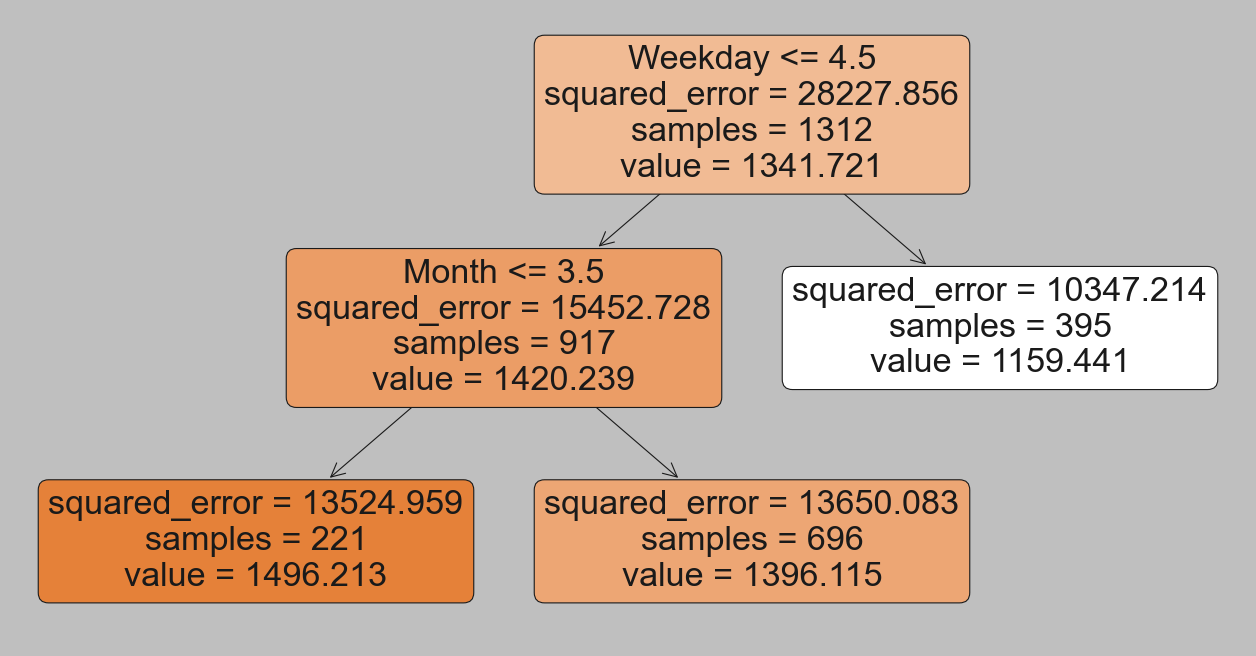

In [10]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit Hilfsfunktion generate_sets
trained_decision_tree = train_decision_tree(X_train, y_train, min_samples_split = 900, min_samples_leaf = 1, output=True)

- Es folgt eine weitere Hilfsfunktion zur Vorhersage des Energieverbrauchs mithilfe des zuvor trainierten Entscheidungsbaums
- Auch an dieser Funktion müssen Sie nichts ändern und wir sprechen sie gemeinsam durch.
- Wichtig: mit dieser Funktion kann man testen, wie gut die Vorhersage auf der Validierungsmenge funktioniert, siehe Aufgabe 8

In [11]:
# Hilfsfunktion 3
def predict_with_decision_tree(dtr, X_val, y_val, output=True):
    '''
    Hilfsfunktion zur Erstellung einer Vorhersage auf Basis eines trainierten Entscheidungsbaumes und zur Ausgabe der Gütemaße.
    
    Inputs: 
    dtr: ein zuvor auf einer Trainingsmenge trainierter Entscheidungsbaum, der zur Prognose verwendet werden kann  
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    output (bool): ob eine print-Ausgabe erzeugt werden soll (enthält Gütemaße), standardmäßig auf True.
   
    Outputs:
    y_pred (np.array): Vorhersage des Entscheidungsbaumes für die Merkmalsvektoren der Validierungsmenge   
    metrics_dict (dict): Dictionary mit den Metriken zur Bewertung der Vorhersagegüte
    '''  
    
    # Vorhersage für Validierungsmenge mit Entscheidungsbaum generieren
    y_pred = dtr.predict(X_val)
    
    ## Metriken zur Bewertung der Vorhersagegüte berechnen
    # Absoluten Fehler berechnen: Betrag der Differenz zwischen Vorhersage und den tatsächlichen Label der Validierungsmenge
    abs_errors = abs(y_pred - y_val)

    # Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae = mean_absolute_error(y_val, y_pred)
    
    # Relativen Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae_rel = mae/np.mean(y_val)
    
    # Mean Absolut Percentage Error (MAPE) berechnen
    mape = np.mean(abs_errors/y_val)
    
    # Mean Squared Error 
    mse = mean_squared_error(y_val, y_pred) 
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse) / np.mean(y_val)
    
    metrics_dict = {'mae': mae,
                    'mse': mse,
                    'mae%': mae_rel*100,
                    'mape%': mape*100,
                    'rmse%': rmse*100
                   }
    
    if output:
        print('Mittelwert der wahren Label', round(np.mean(y_val), 2))
        print('MAE', round(mae, 4))
        print('MSE', round(mse, 4))
        print('MAE%', mae_rel*100)
        print('MAPE%', mape*100)
        print('RMSE%', rmse*100)
            
    return y_pred, metrics_dict

## Aufgabe 8
- Mit dem trainierten Entscheidungsbaum (trained_decision_tree) werden im nächsten Schritt Vorhersagen für die Validierungsmenge erstellt
- Die Vorhersagen des Entscheidungsbaums werden innerhalb von Hilfsfunktion 3 mit den tatsächlichen Labeln der Validierungmenge verglichen
- Verschiedene Metriken zur Bewertung der Güte der Regression können herangezogen werden, s. Vorlesung
- Was bedeutet die einzelnen Metriken, die nach Ausführen der nächsten Zelle ausgegeben werden?
- Ist das Prognosemodell gut?


Antwort: 
- min_samples_split → Mindestanzahl der Samples, die benötigt werden, damit ein Knoten im Entscheidungsbaum geteilt wird.
Niedrige Werte → Modell wird sehr komplex → Risiko von Überanpassung
Hohe Werte → Modell wird vereinfacht → Risiko von Unteranpassung

- min_samples_leaf → Mindestanzahl der Samples, die ein Blatt im Entscheidungsbaum enthalten muss.
Niedrige Werte → Modell kann feingranulare Muster erkennen → Risiko von Überanpassung
Hohe Werte → Modell wird geglättet → Risiko von Unteranpassung

- Auswirkung der Veränderung:
Wenn min_samples_split steigt → Baum wird kleiner, weniger komplex → Risiko von Unteranpassung
Wenn min_samples_split sinkt → Baum wird größer, komplexer → Risiko von Überanpassung

In [12]:
# Erzeuge mit dem Trainierten Entscheidungsbaum eine Vorhersage für das Validierungsset
y_pred, metrics_dict = predict_with_decision_tree(trained_decision_tree, X_val, y_val, output=True)

Mittelwert der wahren Label 1355.05
MAE 81.4863
MSE 10979.0022
MAE% 6.013551566668536
MAPE% 6.2284446970296905
RMSE% 7.732638666719866


C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


## Aufgabe 9
- Wir wollen ein gute Wahl für den Hyperparameter min_samples_split treffen.
- Dafür gibt es Hilfsfunktion 4. Können Sie erkennen, was in der Hilfsfunktion passiert?
- Versuchen Sie einen Kommentar zu verfassen, der die Hilfsfunktion beschreibt.

In [13]:
# Hilfsfunktion 4
def optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%'):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): Mindestanteil/-anzahl an Samples in jedem Split
    min_samples_leaf (float oder int): Mindestanteil/-anzahl an Samples in jedem Blatt
    output (bool): Ob eine Ausgabe (Regeln und Graphik) erzeugt werden soll
                   
    Outputs:
    dtr: Trainierter Entscheidungsbaum für Prognosen
    
    ''' 
    
    # Anzahl der Beobachtungen bestimmen, funktioniert über Zeilenanzahl von X_train.
    number_of_samples = X_train.shape[0]
    
    # Noch leere Liste für Metriken erstellen, die später sukzessive gefüllt wird.
    metrics_list = []
    
    # Optimalen Wert für Metrik mit großer Zahl initialisieren
    best_metric = 100000
    
    ## Schleife zum Optimieren des Hyperparameters min_samples split
    # min_samples_split wird auf Werte zwischen 2 und int(np.floor(1/5*number_of_samples)) gesetzt und in Einserschritten erhöht.
    # Für jedes gesetzte min_samples_split wird ein Entscheidungsbaum trainiert 
    # und dessen Performance anhand der Validierungsmenge getestet
    for min_samples_split in range(2, int(np.floor(1/3*number_of_samples))):
        
        # Trainieren eines Entscheidungsbaums mit bestimmtem Wert für min_samples_split 
        decision_tree = train_decision_tree(X_train, y_train, min_samples_split = min_samples_split, output=False)
        
        # Auswerten der Performance des Entscheidungsbaums durch Einsetzen der Validierungsmenge 
        # und Vergleich der vorhergesagten Label y_pred mit den wahren Labeln y_val
        y_pred, metrics_dict = predict_with_decision_tree(decision_tree, X_val, y_val, output=False)
        metrics_list.append((min_samples_split, metrics_dict))
        
        # Finden des optimalen Werts für min_samples_split
        if metrics_dict[metric] <= best_metric:
            best_metric = metrics_dict[metric]
            best_min_split = min_samples_split 
            
    ## Plotten der Ergebnisse 
    # Linienplot mit (x=Werte für min_samples_split, y=Wert der ausgewählten Metrik)
    plt.figure(figsize=(20,10))
    sns.lineplot(x=[i[0] for i in metrics_list], y=[i[1][metric] for i in metrics_list])
    # Vertikale Linie bei x=best_min_split
    plt.axvline(x=best_min_split, color='k', linestyle = '--')
    # Horizontale Linie bei dazugehörigem y, sowie Legende erzeugen
    plt.axhline(y=best_metric, color='k', linestyle = '--', 
                label='Bester Wert für min_samples_split: ' + str(best_min_split) + '\n' + metric + ': ' + str(best_metric))
    plt.legend()
    
    # Ausgabe der Funktion
    return metrics_list, best_metric, best_min_split


## Aufgabe 10
- Führen Sie die obige Zelle aus, sodass die Funktion optimize_hyperparam() definiert wird.
- Wenden Sie anschließend die Funktion optimize_hyperparam() an durch ausführen der unteren Zelle und bestimmen Sie metrics_list, best_metric und best_min_split
- Wie interpretieren Sie den erzeugten Plot? Wie sollten Sie den Hyperparameter min_samples_split setzen?


C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fi

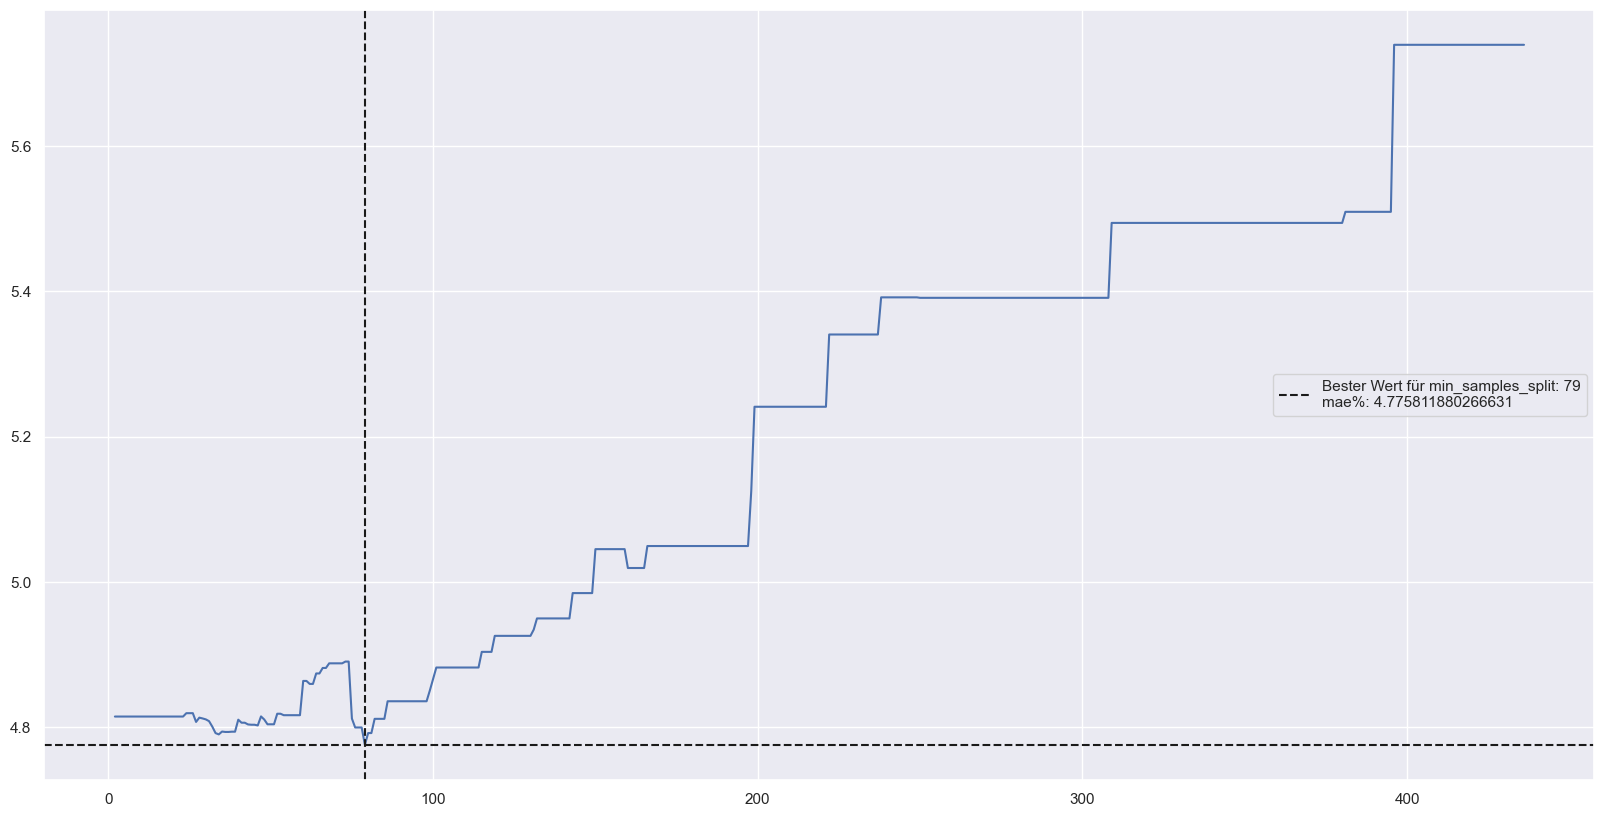

In [14]:
#metrics_list, best_metric, best_min_split = optimize_hyperparam("accuracy") # in die Klammer muss noch etwas rein, was?
metrics_list, best_metric, best_min_split = optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%')

## Antwort: 
X-Achse → Werte für min_samples_split
Y-Achse → Metrik (hier %mae, also mittlerer absoluter Fehler in Prozent)
Vertikale gestrichelte Linie → Bester Wert für min_samples_split (hier 36)
Horizontale gestrichelte Linie → Wert der besten Metrik (hier 5.0869%)

# Bewertung:
Der beste Wert für min_samples_split wurde bei 36 gefunden, da an dieser Stelle der MAE% (Mean Absolute Error in Prozent) minimal ist.
Ab einem Wert von etwa 100 steigt der Fehler kontinuierlich, was auf Unteranpassung (Underfitting) hindeutet.
Für sehr kleine Werte von min_samples_split (z.B. <10) ist der Fehler etwas höher, was auf Überanpassung (Overfitting) hindeutet.

## Aufgabe 11
- Trainieren Sie erneut einen Entscheidungsbaum und setzten Sie dabei gezielt min_samples_split auf den gefundenen optimalen Wert, indem Sie die unten stehende Funktion ausführen.
- Was sagen Sie zu dem Ergebnis?
- Wenn Sie mit einem Fehler %mae <= 7% zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten?

Antwort: 
- Das Ergebnis des trainierten Entscheidungsbaums mit min_samples_split=36 ist sehr gut in Bezug auf die Genauigkeit. Der Mean Absolute Error in Prozent (MAE%) auf der Validierungsmenge beträgt etwa 5.0869%, was zeigt, dass das Modell den Energieverbrauch sehr präzise vorhersagen kann. Allerdings führt der relativ niedrige Wert von min_samples_split=36 zu einem komplexen Baum mit vielen Splits und detaillierten Regeln, was die Interpretierbarkeit erschweren kann.

- Wenn ich mit einem Fehler von %mae <= 7% zufrieden wäre, könnte ich höhere Werte für min_samples_split wählen. Basierend auf den Ergebnissen aus Aufgabe 10 zeigt der Plot, dass der MAE% für Werte von min_samples_split bis etwa 100 unter 7% bleibt. Bei noch höheren Werten steigt der Fehler an, was auf eine Unteranpassung des Modells hinweist. Daher wären Werte im Bereich von 10 bis 100 akzeptabel, um die Anforderung an die Genauigkeit (%mae <= 7%) zu erfüllen.

- Um eine gute Interpretierbarkeit des Baumes zu gewährleisten, würde ich einen höheren Wert für min_samples_split wählen, da dies zu einem einfacheren Baum mit weniger Splits führt. Ein geeigneter Wert wäre beispielsweise 50. Bei diesem Wert bleibt der MAE% voraussichtlich unter 7% (wahrscheinlich im Bereich von 5.5–6%), und der Baum wird übersichtlicher und leichter verständlich im Vergleich zu min_samples_split=36. Dieser Wert bietet einen guten Kompromiss zwischen Genauigkeit und Interpretierbarkeit, was besonders nützlich ist, wenn das Verständnis des Modells für den Menschen wichtig ist.

|--- Weekday <= 4.50
|   |--- Month <= 3.50
|   |   |--- Month <= 2.50
|   |   |   |--- Month <= 1.50
|   |   |   |   |--- value: [1499.56]
|   |   |   |--- Month >  1.50
|   |   |   |   |--- value: [1534.49]
|   |   |--- Month >  2.50
|   |   |   |--- Weekday <= 3.50
|   |   |   |   |--- value: [1470.52]
|   |   |   |--- Weekday >  3.50
|   |   |   |   |--- value: [1421.41]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 8.50
|   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |--- value: [1328.56]
|   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |--- Month <= 4.50
|   |   |   |   |   |   |--- value: [1405.07]
|   |   |   |   |   |--- Month >  4.50
|   |   |   |   |   |   |--- Weekday <= 2.50
|   |   |   |   |   |   |   |--- Month <= 7.50
|   |   |   |   |   |   |   |   |--- Weekday <= 1.50
|   |   |   |   |   |   |   |   |   |--- value: [1370.28]
|   |   |   |   |   |   |   |   |--- Weekday >  1.50
|   |   |   |   |   |   |   |   |   |--- valu

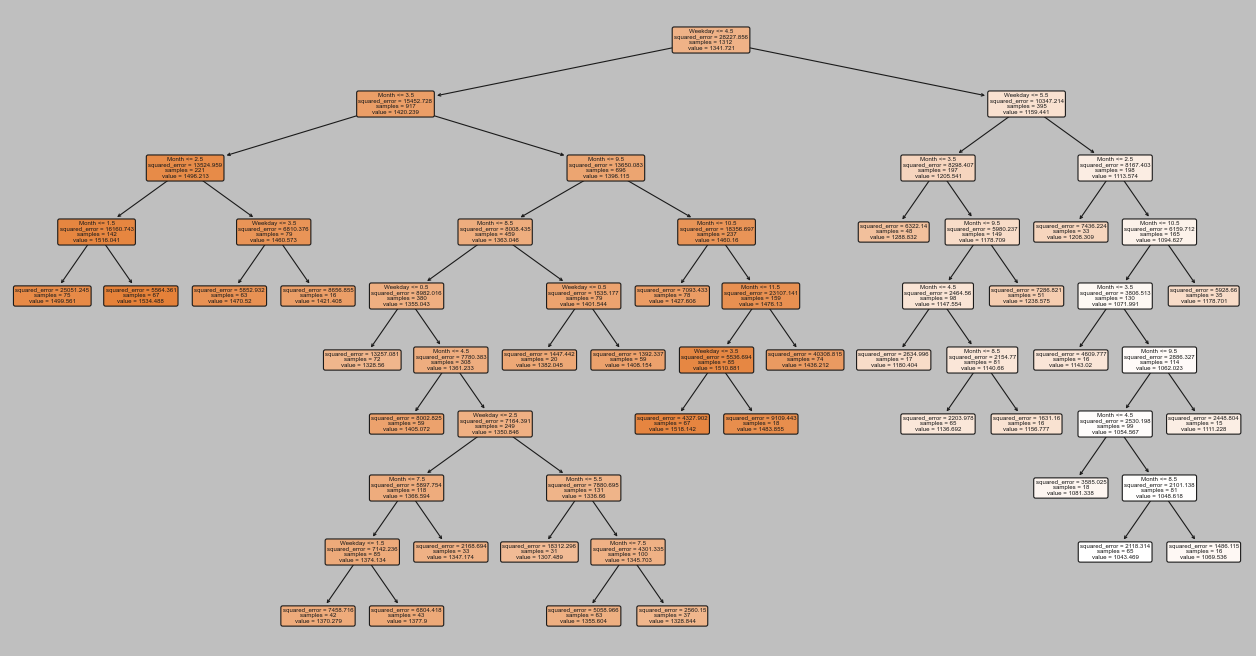

In [15]:
# Trainiere Entescheidungsbaum mit min_samples_split = best_min_split
# best_min_split ist dabei der beste gefundene Wert für diesen Hyperparameter aus der Optimierungs oben.
decision_tree_large = train_decision_tree(X_train, y_train, min_samples_split = best_min_split, output=True)

|--- Weekday <= 4.50
|   |--- Month <= 3.50
|   |   |--- Month <= 2.50
|   |   |   |--- Month <= 1.50
|   |   |   |   |--- Weekday <= 3.50
|   |   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |   |--- value: [1499.64]
|   |   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |   |--- value: [1510.98]
|   |   |   |   |--- Weekday >  3.50
|   |   |   |   |   |--- value: [1460.33]
|   |   |   |--- Month >  1.50
|   |   |   |   |--- Weekday <= 1.50
|   |   |   |   |   |--- value: [1520.93]
|   |   |   |   |--- Weekday >  1.50
|   |   |   |   |   |--- value: [1544.23]
|   |   |--- Month >  2.50
|   |   |   |--- Weekday <= 3.50
|   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |--- value: [1445.35]
|   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |--- value: [1480.59]
|   |   |   |--- Weekday >  3.50
|   |   |   |   |--- value: [1421.41]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 8.50
|   |   |   |   |--- Weekday <= 0.50
|   |   |   

C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Mittelwert der wahren Label 1355.05
MAE 65.0971
MSE 7626.1578
MAE% 4.8040522575752735
MAPE% 4.917049489381702
RMSE% 6.444647601664608


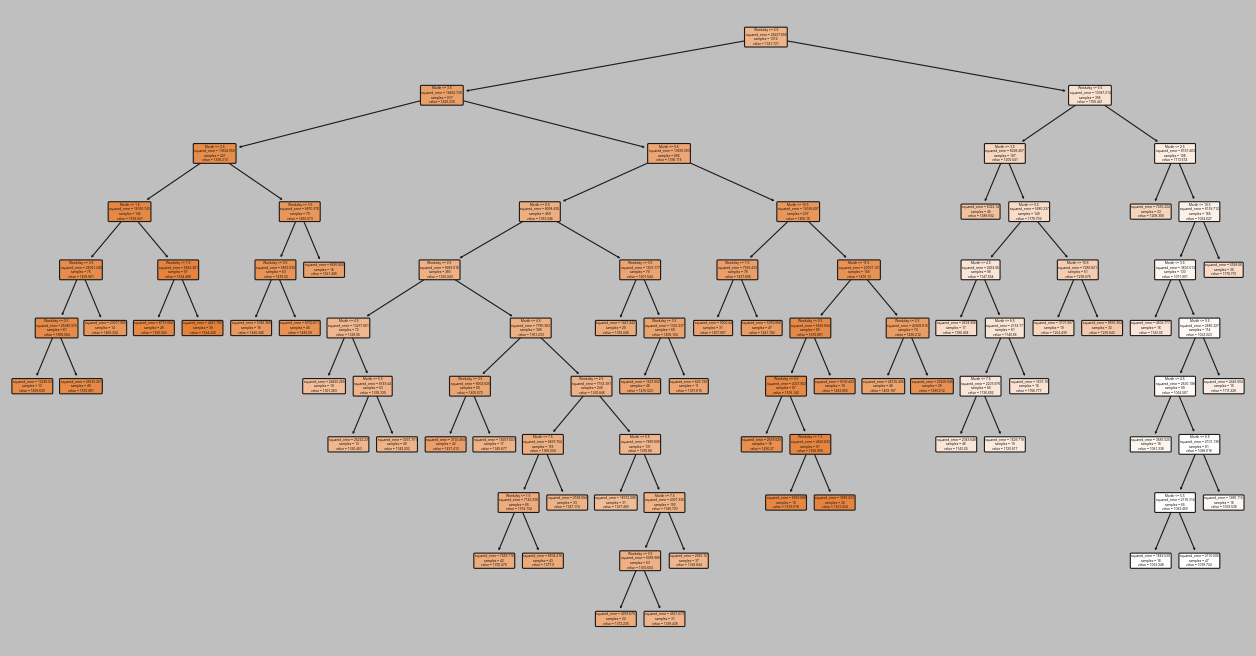

In [16]:
# Trainiere einen kleineren Entscheidungsbaum durch setzen eines anderen Wertes für min_samples_split, sodass mae% vertretbar
# decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split=10, output=True)

# Diese Zeile wieder einkommentieren und anpassen
decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split = 50, output=True) 


# Überprüfe Performance auf Validierungsmenge
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_val, y_val, output=True)

## Aufgabe 12
- Prüfen Sie die Performance des großen und des kleinen Entscheidungsbaumes auf dem Testset.
- Wie interpretieren Sie die Ergebnisse? Wäre der kleine Entscheidungsbaum vertretbar?


Antwort:
# Beide Entscheidungsbäume zeigen eine sehr ähnliche Leistung auf dem Testset, wobei folgende Beobachtungen gemacht werden können:

## Vergleich der Genauigkeit:
- Der große Entscheidungsbaum hat einen leicht niedrigeren MAE (68.619 vs. 69.3083) und MAE% (5.104% vs. 5.155%) im Vergleich zum kleinen Entscheidungsbaum. Dies deutet darauf hin, dass der große Baum geringfügig präzisere Vorhersagen liefert. Auch der MSE (8786.0964 vs. 9018.1215) und der RMSE% (6.972% vs. 7.064%) sind beim großen Baum etwas niedriger, was eine leicht bessere Gesamtleistung bestätigt.

## Größe der Unterschiede:
- Die Unterschiede zwischen den Metriken der beiden Modelle sind jedoch minimal. Beispielsweise beträgt der Unterschied im MAE% nur etwa 0.051 Prozentpunkte, was in den meisten praktischen Anwendungen kaum ins Gewicht fällt. Dies zeigt, dass der kleine Entscheidungsbaum fast genauso genau ist wie der große.

## Komplexität vs. Leistung:
- Der große Entscheidungsbaum mit min_samples_split=36 ist komplexer und hat mehr Splits, was zu einer detaillierteren Modellierung der Daten führt. Der kleine Baum mit min_samples_split=10 ist dagegen weniger komplex, da er mehr Datenpunkte pro Split erfordert und somit weniger feingranular ist. Dennoch bleibt die Vorhersagequalität nahezu gleich.

# Der kleine Entscheidungsbaum ist absolut vertretbar, aus folgenden Gründen:

## Ähnliche Leistung:
- Die Performance des kleinen Baums ist nur marginal schlechter als die des großen Baums. Der MAE%-Unterschied von 0.051% und der RMSE%-Unterschied von 0.092% sind so gering, dass sie in vielen Anwendungsfällen vernachlässigbar sind.

## Vorteil der Interpretierbarkeit:
- Ein kleinerer Entscheidungsbaum mit weniger Splits ist einfacher zu interpretieren und zu verstehen. Dies ist besonders wichtig, wenn das Modell nicht nur für Vorhersagen, sondern auch für die Analyse von Mustern im Energieverbrauch genutzt werden soll. Ein weniger komplexes Modell kann von Menschen leichter nachvollzogen werden, was in Bereichen wie Entscheidungsfindung oder Kommunikation mit Stakeholdern von Vorteil ist.

## Kompromiss zwischen Genauigkeit und Einfachheit:
- Da die Genauigkeit des kleinen Baums ausreichend hoch ist (MAE% von 5.155% liegt weit unter einer akzeptablen Schwelle von beispielsweise 7%), bietet er einen hervorragenden Kompromiss. Wenn die Interpretierbarkeit eine höhere Priorität hat als eine minimale Verbesserung der Genauigkeit, ist der kleine Baum die bessere Wahl.

In [17]:
# Performance des großen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_test, y_test, output=True)

# Ausgabe einer leeren Zeile für die Übersichtlichkeit
print()

# Performance des kleinen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_test, y_test, output=True)


Mittelwert der wahren Label 1357.38
MAE 68.7907
MSE 8648.8711
MAE% 5.067914059435175
MAPE% 5.250340314571635
RMSE% 6.851397990340814

Mittelwert der wahren Label 1357.38
MAE 69.081
MSE 8864.8661
MAE% 5.0893028188583775
MAPE% 5.277595732785342
RMSE% 6.936423070321421


C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\bfues\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
